# Recommending Movies Using Affinity Analysis

Here, we will look at affinity analysis that determines when objects occur frequently together. This is colloquially called market basket analysis, after one of the use cases of determining when items are purchased together frequently.

The key concepts of this chapter are as follows:
- Affinity analysis
- Feature association mining using the Apriori algorithm
- Movie recommendations
- Sparse data formats

## Affinity analysis

Affinity analysis is the task of determining when objects are used in similar ways. In the previous section, we focused on whether the objects themselves are similar. The data for affinity analysis is often described in the form of a **transaction**. Intuitively, this comes from a transaction at a store—determining when objects are purchased together. 

However, it can be applied to many processes:
- Fraud detection
- Customer segmentation
- Software optimization
- Product recommendations

Affinity analysis is usually much more exploratory than classification. We often don't have the complete dataset we expect for many classification tasks. For instance, in movie recommendation, we have reviews from different people on different movies. However, it is unlikely we have each reviewer review all of the movies in our dataset. This leaves an important and difficult question in affinity analysis. If a reviewer hasn't reviewed a movie, is that an indication that they aren't interested in the movie (and therefore wouldn't recommend it) or simply that they haven't reviewed it yet?

## Algorithms for affinity analysis

With a naive rule creation, such as our previous algorithm, the growth in time needed to compute these rules increases exponentially. As we add more items, the time it takes to compute all rules increases significantly faster. Specifically, the total possible number of rules is 2n - 1. For our five-item dataset, there are 31 possible rules. For 10 items, it is 1023. For just 100 items, the number has 30 digits. Even the drastic increase in computing power couldn't possibly keep up with the increases in the number of items stored online. Therefore, we need algorithms that work smarter, as opposed to computers that work harder.

The classic algorithm for affinity analysis is called the **Apriori algorithm**. It addresses the exponential problem of creating sets of items that occur frequently within a database, called **frequent itemsets**. Once these frequent itemsets are discovered, creating association rules is straightforward.

The intuition behind Apriori is both simple and clever. First, we ensure that a rule has sufficient support within the dataset. Defining a minimum support level is the key parameter for Apriori. To build a frequent itemset, for an itemset (A, B) to have a support of at least 30, both A and B must occur at least 30 times in the database. This property extends to larger sets as well. For an itemset (A, B, C, D) to be considered
frequent, the set (A, B, C) must also be frequent (as must D).

These frequent itemsets can be built up and possible itemsets that are not frequent (of which there are many) will never be tested. This saves significant time in testing new rules.

Other example algorithms for affinity analysis include the **Eclat** and **FP-growth** algorithms. There are many improvements to these algorithms in the data mining literature that further improve the efficiency of the method.

## Choosing parameters

To perform association rule mining for affinity analysis, we first use the Apriori to generate frequent itemsets. Next, we create association rules (for example, if a person recommended movie X, they would also recommend movie Y) by testing combinations of premises and conclusions within those frequent itemsets.

For the first stage, the Apriori algorithm needs a value for the minimum support that an itemset needs to be considered frequent. Any itemsets with less support will not be considered. Setting this minimum support too low will cause Apriori to test a larger number of itemsets, slowing the algorithm down. Setting it too high will result in fewer itemsets being considered frequent.

In the second stage, after the frequent itemsets have been discovered, association
rules are tested based on their confidence. We could choose a minimum confidence
level, a number of rules to return, or simply return all of them and let the user decide
what to do with them.

Here, we will return only rules above a given confidence level. Therefore, we need to set our minimum confidence level. Setting this too low will result in rules that have a high support, but are not very accurate. Setting this higher will result in only more accurate rules being returned, but with fewer rules being discovered.

## The movie recommendation problem

Product recommendation is big business. Online stores use it to up-sell to customers by recommending other products that they could buy. Making better recommendations leads to better sales. When online shopping is selling to millions of customers every year, there is a lot of potential money to be made by selling more
items to these customers.

**Aside**: Product recommendations have been researched for many years; however, the field gained a significant boost when Netflix ran their Netflix Prize between 2007 and 2009. This competition aimed to determine if anyone can predict a user's rating of a film better than Netflix was currently doing. The prize went to a team that was just over 10 percent better than the current solution. While this may not seem like a large improvement, such an improvement would net millions to Netflix in revenue from better movie recommendations.

## Obtaining the dataset

Since the inception of the Netflix Prize, Grouplens, a research group at the University of Minnesota, has released several datasets that are often used for testing algorithms in this area. They have released several versions of a movie rating dataset, which have different sizes. There is a version with 100,000 reviews, one with 1 million reviews and one with 10 million reviews.

The datasets are available from http://grouplens.org/datasets/movielens/ and the dataset we are going to use is the MovieLens 1 million dataset. Download this dataset and unzip it in your data folder.

In [33]:
DATA = 'data/ml-100k/'
RATINGS = DATA + 'u.data'
MOVIES = DATA + 'u.item'

In [34]:
import pandas as pd

In [35]:
all_ratings = pd.read_csv(RATINGS, delimiter="\t", header=None, names = ["UserID", "MovieID", "Rating", "Datetime"])
all_ratings["Datetime"] = pd.to_datetime(all_ratings['Datetime'],unit='s')
all_ratings.head()

,UserID,MovieID,Rating,Datetime
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


## Sparse data formats

This dataset is in a **sparse matrix** format. Each row can be thought of as a cell in a large feature matrix, where rows are users and columns are individual movies. The first column would be each user's review of the first movie, the second column would be each user's review of the second movie, and so on.

There are 1,000 users and 1,700 movies in this dataset, which means that the full matrix would be quite large. We may run into issues storing the whole matrix in memory and computing on it would be troublesome. However, this matrix has the property that most cells are empty, that is, there is no review for most movies for most users. There is no review of movie #675 for user #213 though, and not for most other combinations of user and movie.

In [36]:
all_ratings[all_ratings['MovieID']=='675'].head()

,UserID,MovieID,Rating,Datetime


In [37]:
all_ratings[all_ratings['MovieID']=='213'].head()

,UserID,MovieID,Rating,Datetime


## The Apriori implementation

**Goal:**  produce rules of the following form: i*f a person recommends these movies, they will also recommend this movie.*

We will also discuss extensions where a person recommends a set of movies is likely to recommend another particular movie. To do this, we first need to determine if a person recommends a movie. We can do this by creating a new feature Favorable, which is True if the person gave a favorable review to a movie:

In [38]:
# Not all reviews are favourable! Our goal is "other recommended books", so we only want favourable reviews
all_ratings["Favorable"] = all_ratings["Rating"] > 3
all_ratings[10:15]

,UserID,MovieID,Rating,Datetime,Favorable
10,62,257,2,1997-11-12 22:07:14,False
11,286,1014,5,1997-11-17 15:38:45,True
12,200,222,5,1997-10-05 09:05:40,True
13,210,40,3,1998-03-27 21:59:54,False
14,224,29,3,1998-02-21 23:40:57,False


In [39]:
all_ratings[all_ratings["UserID"] == 1].head()

,UserID,MovieID,Rating,Datetime,Favorable
202,1,61,4,1997-11-03 07:33:40,True
305,1,189,3,1998-03-01 06:15:28,False
333,1,33,4,1997-11-03 07:38:19,True
334,1,160,4,1997-09-24 03:42:27,True
478,1,20,4,1998-02-14 04:51:23,True


We will sample our dataset to form a training dataset. This also helps reduce the size of the dataset that will be searched, making the Apriori algorithm run faster. We obtain all reviews from the first 200 users:

In [40]:
# Sample the dataset. 
# You can try increasing the size of the sample, but the run time will be considerably longer
ratings = all_ratings[all_ratings['UserID'].isin(range(200))]

In [41]:
# We start by creating a dataset of each user's favourable reviews
favorable_ratings = ratings[ratings["Favorable"]]
favorable_ratings.head()

,UserID,MovieID,Rating,Datetime,Favorable
16,122,387,5,1997-11-11 17:47:39,True
20,119,392,4,1998-01-30 16:13:34,True
21,167,486,4,1998-04-16 14:54:12,True
26,38,95,5,1998-04-13 01:14:54,True
28,63,277,4,1997-10-01 23:10:01,True


In [42]:
# We are only interested in the reviewers who have more than one review
favorable_reviews_by_users = dict((k, frozenset(v.values)) for k, v in favorable_ratings.groupby("UserID")["MovieID"])
len(favorable_reviews_by_users)

199

In [43]:
# FLet's see the top five movies list
num_favorable_by_movie = ratings[["MovieID", "Favorable"]].groupby("MovieID").sum()
num_favorable_by_movie.sort_values("Favorable", ascending=False).head()

,Favorable
MovieID,
50,100
100,89
258,83
181,79
174,74


## The Apriori algorithm

The Apriori algorithm is part of our affinity analysis and deals specifically with finding frequent itemsets within the data. The basic procedure of Apriori builds up new candidate itemsets from previously discovered frequent itemsets. These candidates are tested to see if they are frequent, and then the algorithm iterates as
explained here:

1. Create initial frequent itemsets by placing each item in its own itemset. Only items with at least the minimum support are used in this step.
2. New candidate itemsets are created from the most recently discovered frequent itemsets by finding supersets of the existing frequent itemsets.
3. All candidate itemsets are tested to see if they are frequent. If a candidate is not frequent then it is discarded. If there are no new frequent itemsets from this step, go to the last step.
4. Store the newly discovered frequent itemsets and go to the second step.
5. Return all of the discovered frequent itemsets.

This process is outlined in the following workflow:

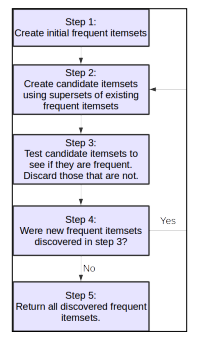

## Implementation

In [44]:
from collections import defaultdict

def find_frequent_itemsets(favorable_reviews_by_users, k_1_itemsets, min_support):
    counts = defaultdict(int)
    for user, reviews in favorable_reviews_by_users.items():
        for itemset in k_1_itemsets:
            if itemset.issubset(reviews):
                for other_reviewed_movie in reviews - itemset:
                    current_superset = itemset | frozenset((other_reviewed_movie,))
                    counts[current_superset] += 1
    return dict([(itemset, frequency) for itemset, frequency in counts.items() if frequency >= min_support])

In [45]:
import sys
frequent_itemsets = {}  # itemsets are sorted by length
min_support = 50

# k=1 candidates are the isbns with more than min_support favourable reviews
frequent_itemsets[1] = dict((frozenset((movie_id,)), row["Favorable"])
                                for movie_id, row in num_favorable_by_movie.iterrows()
                                if row["Favorable"] > min_support)

print(f"There are {len(frequent_itemsets[1])} movies with more than {min_support} favorable reviews")
# We use sys.stdout.flush() to ensure that the printouts happen while the code is still running.
sys.stdout.flush()
for k in range(2, 20):
    # Generate candidates of length k, using the frequent itemsets of length k-1
    # Only store the frequent itemsets
    cur_frequent_itemsets = find_frequent_itemsets(favorable_reviews_by_users, frequent_itemsets[k-1],
                                                   min_support)
    if len(cur_frequent_itemsets) == 0:
        print(f"Did not find any frequent itemsets of length {k}")
        sys.stdout.flush()
        break
    else:
        print(f"I found {len(cur_frequent_itemsets)} frequent itemsets of length {k}")
        #print(cur_frequent_itemsets)
        sys.stdout.flush()
        frequent_itemsets[k] = cur_frequent_itemsets
# We aren't interested in the itemsets of length 1, so remove those
del frequent_itemsets[1]

There are 16 movies with more than 50 favorable reviews
I found 93 frequent itemsets of length 2
I found 295 frequent itemsets of length 3
I found 593 frequent itemsets of length 4
I found 785 frequent itemsets of length 5
I found 677 frequent itemsets of length 6
I found 373 frequent itemsets of length 7
I found 126 frequent itemsets of length 8
I found 24 frequent itemsets of length 9
I found 2 frequent itemsets of length 10
Did not find any frequent itemsets of length 11


You'll notice that the number of itemsets grows as the length increases before it shrinks. It grows because of the increasing number of possible rules. After a while, the large number of combinations no longer has the support necessary to be considered frequent. This results in the number shrinking. This shrinking is the benefit of the Apriori algorithm. If we search all possible itemsets (not just the supersets of frequent ones), we would be searching thousands of times more itemsets to see if they are frequent.

## Extracting association rules

Now, we have a list of frequent itemsets. These aren't exactly association rules, but they are similar to it. A frequent itemset is a set of items with a minimum support, while an association rule has a premise and a conclusion.

We can make an association rule from a frequent itemset by taking one of the movies in the itemset and denoting it as the conclusion. The other movies in the itemset will be the premise. This will form rules of the following form: *if a reviewer recommends all of the movies in the premise, they will also recommend the conclusion.*

For each itemset, we can generate a number of association rules by setting each movie to be the conclusion and the remaining movies as the premise.

In [46]:
frequent_itemsets

{2: {frozenset({1, 7}): 62,
  frozenset({1, 50}): 100,
  frozenset({1, 56}): 64,
  frozenset({1, 64}): 60,
  frozenset({1, 79}): 62,
  frozenset({1, 98}): 72,
  frozenset({1, 100}): 84,
  frozenset({1, 127}): 66,
  frozenset({1, 172}): 60,
  frozenset({1, 174}): 82,
  frozenset({1, 181}): 76,
  frozenset({7, 9}): 50,
  frozenset({7, 50}): 94,
  frozenset({7, 56}): 78,
  frozenset({7, 64}): 64,
  frozenset({7, 79}): 68,
  frozenset({7, 98}): 74,
  frozenset({7, 100}): 94,
  frozenset({7, 127}): 58,
  frozenset({7, 172}): 70,
  frozenset({7, 174}): 78,
  frozenset({7, 181}): 72,
  frozenset({7, 258}): 68,
  frozenset({9, 50}): 70,
  frozenset({9, 56}): 60,
  frozenset({9, 64}): 58,
  frozenset({9, 98}): 58,
  frozenset({9, 100}): 78,
  frozenset({9, 127}): 66,
  frozenset({9, 174}): 54,
  frozenset({9, 181}): 52,
  frozenset({50, 56}): 92,
  frozenset({50, 64}): 82,
  frozenset({50, 79}): 84,
  frozenset({50, 98}): 96,
  frozenset({50, 100}): 110,
  frozenset({50, 127}): 102,
  frozenset

In [47]:
# Now we create the association rules. First, they are candidates until the confidence has been tested
candidate_rules = []
for itemset_length, itemset_counts in frequent_itemsets.items():
    for itemset in itemset_counts.keys():
        for conclusion in itemset:
            premise = itemset - set((conclusion,))
            candidate_rules.append((premise, conclusion))
print(f"There are {len(candidate_rules)} candidate rules")

There are 15285 candidate rules


In [48]:
print(candidate_rules[:5])

[(frozenset({7}), 1), (frozenset({1}), 7), (frozenset({50}), 1), (frozenset({1}), 50), (frozenset({1}), 56)]


In [49]:
# Now, we compute the confidence of each of these rules. This is very similar to what we did in chapter 1
correct_counts = defaultdict(int)
incorrect_counts = defaultdict(int)
for user, reviews in favorable_reviews_by_users.items():
    for candidate_rule in candidate_rules:
        premise, conclusion = candidate_rule
        if premise.issubset(reviews):
            if conclusion in reviews:
                correct_counts[candidate_rule] += 1
            else:
                incorrect_counts[candidate_rule] += 1
rule_confidence = {candidate_rule: correct_counts[candidate_rule] / float(correct_counts[candidate_rule] + incorrect_counts[candidate_rule])
              for candidate_rule in candidate_rules}

In [50]:
# Choose only rules above a minimum confidence level
min_confidence = 0.9

In [51]:
# Filter out the rules with poor confidence
rule_confidence = {rule: confidence for rule, confidence in rule_confidence.items() if confidence > min_confidence}
print(len(rule_confidence))

5152


In [52]:
from operator import itemgetter
sorted_confidence = sorted(rule_confidence.items(), key=itemgetter(1), reverse=True)

In [53]:
for index in range(5):
    print("Rule #{0}".format(index + 1))
    (premise, conclusion) = sorted_confidence[index][0]
    print(f"Rule: If a person recommends {premise} they will also recommend {conclusion}")
    print(f" - Confidence: {rule_confidence[(premise, conclusion)]:.3f}")
    print("")

Rule #1
Rule: If a person recommends frozenset({98, 181}) they will also recommend 50
 - Confidence: 1.000

Rule #2
Rule: If a person recommends frozenset({172, 79}) they will also recommend 174
 - Confidence: 1.000

Rule #3
Rule: If a person recommends frozenset({258, 172}) they will also recommend 174
 - Confidence: 1.000

Rule #4
Rule: If a person recommends frozenset({1, 181, 7}) they will also recommend 50
 - Confidence: 1.000

Rule #5
Rule: If a person recommends frozenset({1, 172, 7}) they will also recommend 174
 - Confidence: 1.000



In [54]:
# Even better, we can get the movie titles themselves from the dataset
movie_name_data = pd.read_csv(MOVIES, delimiter="|", header=None, encoding = "mac-roman")
movie_name_data.columns = ["MovieID", "Title", "Release Date", "Video Release", "IMDB", "", "Action", "Adventure",
                           "Animation", "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir",
                           "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]

In [55]:
def get_movie_name(movie_id):
    title_object = movie_name_data[movie_name_data["MovieID"] == movie_id]["Title"]
    title = title_object.values[0]
    return title

In [56]:
get_movie_name(4)

'Get Shorty (1995)'

In [57]:
for index in range(5):
    print("Rule #{0}".format(index + 1))
    (premise, conclusion) = sorted_confidence[index][0]
    premise_names = ", ".join(get_movie_name(idx) for idx in premise)
    conclusion_name = get_movie_name(conclusion)
    print("Rule: If a person recommends {0} they will also recommend {1}".format(premise_names, conclusion_name))
    print(" - Confidence: {0:.3f}".format(rule_confidence[(premise, conclusion)]))
    print("")

Rule #1
Rule: If a person recommends Silence of the Lambs, The (1991), Return of the Jedi (1983) they will also recommend Star Wars (1977)
 - Confidence: 1.000

Rule #2
Rule: If a person recommends Empire Strikes Back, The (1980), Fugitive, The (1993) they will also recommend Raiders of the Lost Ark (1981)
 - Confidence: 1.000

Rule #3
Rule: If a person recommends Contact (1997), Empire Strikes Back, The (1980) they will also recommend Raiders of the Lost Ark (1981)
 - Confidence: 1.000

Rule #4
Rule: If a person recommends Toy Story (1995), Return of the Jedi (1983), Twelve Monkeys (1995) they will also recommend Star Wars (1977)
 - Confidence: 1.000

Rule #5
Rule: If a person recommends Toy Story (1995), Empire Strikes Back, The (1980), Twelve Monkeys (1995) they will also recommend Raiders of the Lost Ark (1981)
 - Confidence: 1.000



## Evaluation

In a broad sense, we can evaluate the association rules using the same concept as for classification. We use a test set of data that was not used for training, and evaluate our discovered rules based on their performance in this test set.

To do this, we will compute the test set confidence, that is, the confidence of each rule on the testing set.

We won't apply a formal evaluation metric in this case; we simply examine the rules and look for good examples.

In [58]:

# Evaluation using test data
test_dataset = all_ratings[~all_ratings['UserID'].isin(range(200))]
test_favorable = test_dataset[test_dataset["Favorable"]]
#test_not_favourable = test_dataset[~test_dataset["Favourable"]]
test_favorable_by_users = dict((k, frozenset(v.values)) for k, v in test_favorable.groupby("UserID")["MovieID"])
#test_not_favourable_by_users = dict((k, frozenset(v.values)) for k, v in test_not_favourable.groupby("UserID")["MovieID"])
#test_users = test_dataset["UserID"].unique()

In [59]:
test_dataset[:5]

,UserID,MovieID,Rating,Datetime,Favorable
3,244,51,2,1997-11-27 05:02:03,False
5,298,474,4,1998-01-07 14:20:06,True
7,253,465,5,1998-04-03 18:34:27,True
8,305,451,3,1998-02-01 09:20:17,False
11,286,1014,5,1997-11-17 15:38:45,True


In [60]:
correct_counts = defaultdict(int)
incorrect_counts = defaultdict(int)
for user, reviews in test_favorable_by_users.items():
    for candidate_rule in candidate_rules:
        premise, conclusion = candidate_rule
        if premise.issubset(reviews):
            if conclusion in reviews:
                correct_counts[candidate_rule] += 1
            else:
                incorrect_counts[candidate_rule] += 1

In [61]:
test_confidence = {candidate_rule: correct_counts[candidate_rule] / float(correct_counts[candidate_rule] + incorrect_counts[candidate_rule])
                   for candidate_rule in rule_confidence}
print(len(test_confidence))

5152


In [62]:
sorted_test_confidence = sorted(test_confidence.items(), key=itemgetter(1), reverse=True)
print(sorted_test_confidence[:5])

[((frozenset({64, 1, 7, 79, 50}), 174), 1.0), ((frozenset({64, 1, 98, 7, 79}), 174), 1.0), ((frozenset({64, 1, 7, 172, 79}), 174), 1.0), ((frozenset({64, 1, 7, 79, 181}), 174), 1.0), ((frozenset({64, 1, 172, 79, 56}), 174), 1.0)]


In [63]:
for index in range(10):
    print(f"Rule #{index + 1}")
    (premise, conclusion) = sorted_confidence[index][0]
    premise_names = ", ".join(get_movie_name(idx) for idx in premise)
    conclusion_name = get_movie_name(conclusion)
    print(f"Rule: If a person recommends {premise_names} they will also recommend {conclusion_name}")
    print(f" - Train Confidence: {rule_confidence.get((premise, conclusion), -1):.3f}")
    print(f" - Test Confidence: {test_confidence.get((premise, conclusion), -1):.3f}")
    print("")

Rule #1
Rule: If a person recommends Silence of the Lambs, The (1991), Return of the Jedi (1983) they will also recommend Star Wars (1977)
 - Train Confidence: 1.000
 - Test Confidence: 0.936

Rule #2
Rule: If a person recommends Empire Strikes Back, The (1980), Fugitive, The (1993) they will also recommend Raiders of the Lost Ark (1981)
 - Train Confidence: 1.000
 - Test Confidence: 0.876

Rule #3
Rule: If a person recommends Contact (1997), Empire Strikes Back, The (1980) they will also recommend Raiders of the Lost Ark (1981)
 - Train Confidence: 1.000
 - Test Confidence: 0.841

Rule #4
Rule: If a person recommends Toy Story (1995), Return of the Jedi (1983), Twelve Monkeys (1995) they will also recommend Star Wars (1977)
 - Train Confidence: 1.000
 - Test Confidence: 0.932

Rule #5
Rule: If a person recommends Toy Story (1995), Empire Strikes Back, The (1980), Twelve Monkeys (1995) they will also recommend Raiders of the Lost Ark (1981)
 - Train Confidence: 1.000
 - Test Confidence